In [2]:
import pandas as pd
import numpy as np
from duckdb import connect
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, time
import tensorflow as tf
import keras
from keras.src.models import Sequential
from keras.src.layers import LSTM, Dense

In [3]:
pd.set_option('display.max_columns', None)

In [37]:
# asof = datetime.combine(datetime.now(), time.min)
asof = datetime(2024, 12, 1)
start_date = datetime(2020, 1, 1)
API_KEY = 'YOUR_DMI_API_KEY'
STATION_ID = '06030'  # Aalborg weather station
LAT, LON = 57.048, 9.9187 # Coordinates for Aalborg

In [38]:
historical_spot_prices = fetch_spot_prices(start_date, asof)
historical_wind_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'wind_speed', historical=True)
historical_temp_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'temp_dry', historical=True)

In [39]:
df = preprocess_data(historical_spot_prices, historical_wind_data, historical_temp_data)

In [40]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

In [41]:
# Normalize data
X_train, X_val, X_test, y_train, y_val, y_test, scaler_y = normalize_data(X_train, X_val, X_test, y_train, y_val, y_test)

NameError: name 'normalize_data' is not defined

In [42]:
print(X_train)

           hour_sin      hour_cos  weekday_sin  weekday_cos  wind_speed  \
42738 -1.000000e+00 -1.836970e-16    -0.433884    -0.900969    9.300000   
25854  1.000000e+00  6.123234e-17     0.781831     0.623490    0.583333   
25735  9.659258e-01 -2.588190e-01     0.433884    -0.900969    5.400000   
12875  1.224647e-16 -1.000000e+00    -0.781831     0.623490    4.950000   
10575 -7.071068e-01 -7.071068e-01     0.781831     0.623490    1.716667   
...             ...           ...          ...          ...         ...   
6400  -9.659258e-01 -2.588190e-01     0.974928    -0.222521    3.516667   
11505  5.000000e-01 -8.660254e-01    -0.974928    -0.222521    3.266667   
38519  0.000000e+00  1.000000e+00    -0.433884    -0.900969    3.266667   
861   -7.071068e-01  7.071068e-01     0.974928    -0.222521    8.950000   
16048 -9.659258e-01 -2.588190e-01    -0.974928    -0.222521    7.283333   

       temperature  
42738     9.483333  
25854    -4.283333  
25735    -3.316667  
12875    17.300

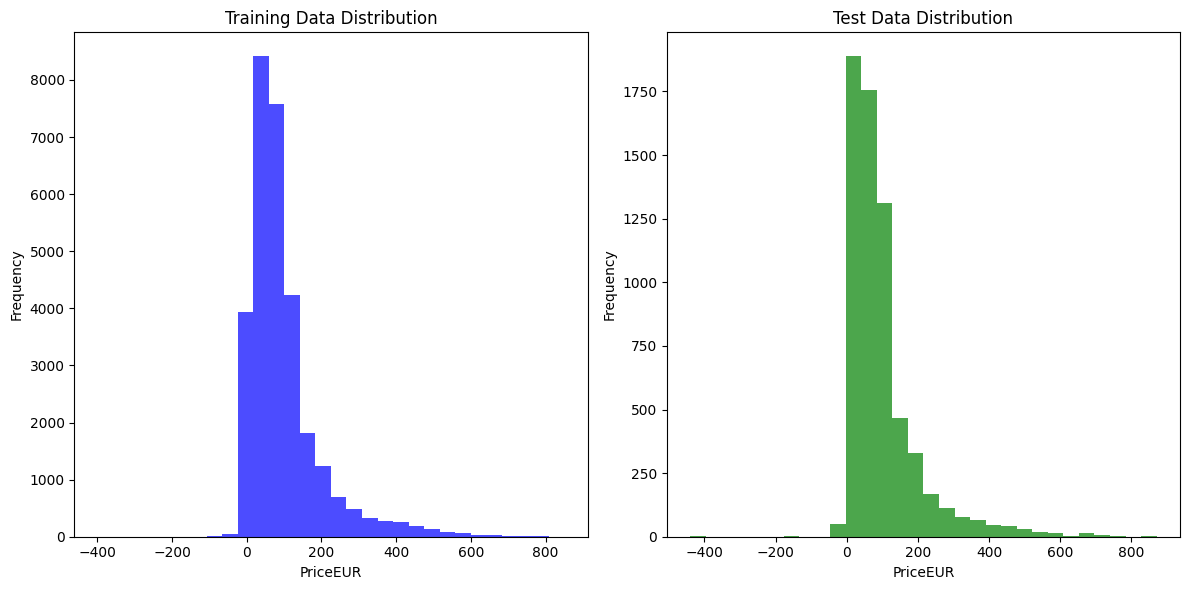

In [43]:
# Plot histograms
plot_histograms(y_train, y_test)

In [44]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(29920, 6) (6411, 6) (6412, 6)
(29920,) (6411,) (6412,)


In [45]:
# Reshape data for LSTM
timesteps = 24  # Or 168 for a week

X_train, X_val, X_test = reshape_data(X_train, X_val, X_test)
# X_train, y_train = reshape_data2(X_train, y_train, timesteps)
# X_val, y_val = reshape_data2(X_val, y_val, timesteps)
# X_test, y_test = reshape_data2(X_test, y_test, timesteps)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(29920, 1, 6) (6411, 1, 6) (6412, 1, 6)
(29920,) (6411,) (6412,)


In [28]:
# Train LSTM model
model, history = train_lstm_model(X_train, y_train, X_val, y_val)

c:\Git\psa_tool\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
935/935 - 8s - 8ms/step - loss: 13448.1270 - val_loss: 11852.7939
Epoch 2/50
935/935 - 4s - 5ms/step - loss: 10867.7383 - val_loss: 10703.8115
Epoch 3/50
935/935 - 5s - 6ms/step - loss: 10036.6182 - val_loss: 10013.1084
Epoch 4/50
935/935 - 5s - 5ms/step - loss: 9509.5479 - val_loss: 9654.0830
Epoch 5/50
935/935 - 4s - 4ms/step - loss: 9290.9062 - val_loss: 9513.7979
Epoch 6/50
935/935 - 4s - 5ms/step - loss: 9193.4844 - val_loss: 9435.2822
Epoch 7/50
935/935 - 4s - 4ms/step - loss: 9130.1484 - val_loss: 9375.0322
Epoch 8/50
935/935 - 4s - 4ms/step - loss: 9076.8174 - val_loss: 9322.2598
Epoch 9/50
935/935 - 5s - 5ms/step - loss: 9023.8057 - val_loss: 9271.8086
Epoch 10/50
935/935 - 5s - 5ms/step - loss: 8971.2002 - val_loss: 9226.5430
Epoch 11/50
935/935 - 4s - 4ms/step - loss: 8922.4453 - val_loss: 9188.4648
Epoch 12/50
935/935 - 4s - 4ms/step - loss: 8880.4141 - val_loss: 9157.9492
Epoch 13/50
935/935 - 4s - 4ms/step - loss: 8846.0322 - val_loss: 9134.4258
Epoch 14/50
935

201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Absolute Error: 64.75 EUR


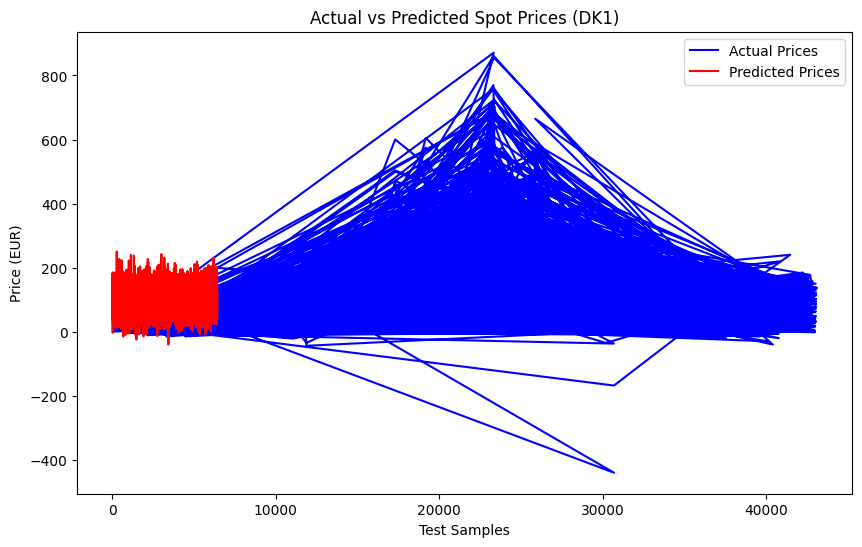

In [46]:
evaluate_model(model, X_test, y_test)

In [36]:
# Load the model for future predictions
model = load_model()

(168, 6)
(168, 1, 6)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


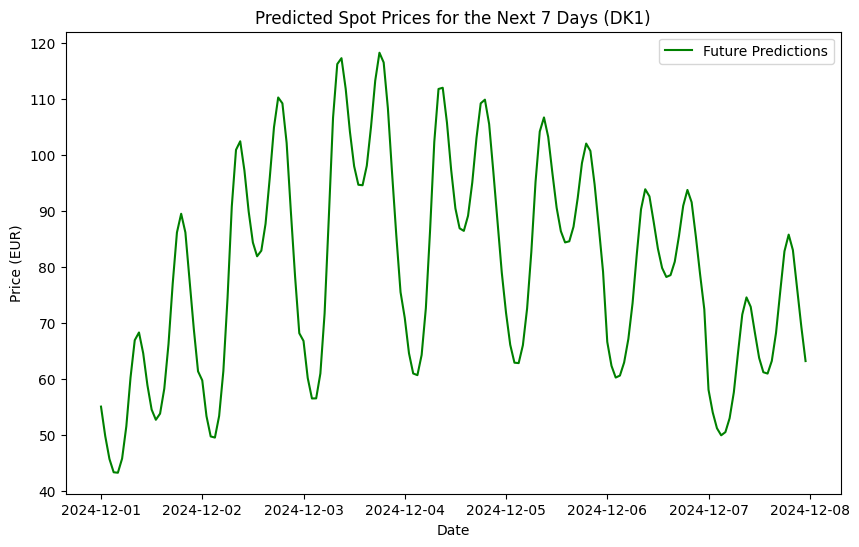

In [47]:
future_df, predictions = predict_future(model, asof)

In [95]:
# # Inverse transform the predictions to get the original scale
future_df['PriceEUR'] = scaler_y.inverse_transform(future_df[['PriceEUR']])
predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [49]:
print(future_df)
print(predictions)

[[[ 0.          1.         -0.78183148  0.6234898   4.6
    6.4       ]]

 [[ 0.25881905  0.96592583 -0.78183148  0.6234898   4.6
    6.4       ]]

 [[ 0.5         0.8660254  -0.78183148  0.6234898   4.6
    6.4       ]]

 ...

 [[-0.70710678  0.70710678 -0.97492791 -0.22252093  4.6
    6.4       ]]

 [[-0.5         0.8660254  -0.97492791 -0.22252093  4.6
    6.4       ]]

 [[-0.25881905  0.96592583 -0.97492791 -0.22252093  4.6
    6.4       ]]]
[[ 55.071037]
 [ 49.818115]
 [ 45.718185]
 [ 43.340637]
 [ 43.26007 ]
 [ 45.78326 ]
 [ 51.538303]
 [ 60.275833]
 [ 66.93677 ]
 [ 68.3154  ]
 [ 64.60792 ]
 [ 58.912544]
 [ 54.542908]
 [ 52.71765 ]
 [ 53.816673]
 [ 58.276596]
 [ 66.24703 ]
 [ 77.09187 ]
 [ 86.17881 ]
 [ 89.52407 ]
 [ 86.1892  ]
 [ 77.651146]
 [ 68.927414]
 [ 61.373398]
 [ 59.760487]
 [ 53.375206]
 [ 49.74328 ]
 [ 49.539555]
 [ 53.39461 ]
 [ 61.403305]
 [ 74.58478 ]
 [ 90.81943 ]
 [100.93912 ]
 [102.47165 ]
 [ 97.22129 ]
 [ 89.92715 ]
 [ 84.387856]
 [ 81.92694 ]
 [ 82.925804]
 [ 8

In [25]:
def normalize_data(X_train, X_val, X_test, y_train, y_val, y_test):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_val = scaler_X.transform(X_val)
    X_test = scaler_X.transform(X_test)

    y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_val = scaler_y.transform(y_val.values.reshape(-1, 1))
    y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler_y

In [6]:
def plot_histograms(y_train, y_test):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(y_train, bins=30, color='blue', alpha=0.7)
    plt.title('Training Data Distribution')
    plt.xlabel('PriceEUR')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(y_test, bins=30, color='green', alpha=0.7)
    plt.title('Test Data Distribution')
    plt.xlabel('PriceEUR')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [7]:
def fetch_data(url, start_date, end_date, parameter, historical=False):
    if historical:
        # Read data from csv file if it exists
        try:
            df = pd.read_csv(f'{parameter}_test.csv')
            df['observed'] = pd.to_datetime(df['observed'])
            return df
        except FileNotFoundError:
            pass
    else:
        params = {
            'datetime': f'{start_date.strftime('%Y-%m-%dT%H:%M:%SZ')}/{end_date.strftime('%Y-%m-%dT%H:%M:%SZ')}',
            'parameterId': parameter,
            'stationId': STATION_ID,
            'limit': 300000
        }
        headers = {'X-Gravitee-Api-Key': API_KEY}
        response = requests.get(url, params=params, headers=headers)
        data = response.json()['features']
        df = pd.DataFrame([obs['properties'] for obs in data])
        df['observed'] = pd.to_datetime(df['observed'])

        # Resample data to hourly frequency
        df.set_index('observed', inplace=True)
        numeric_columns = df.select_dtypes(include=['number']).columns
        df_numeric = df[numeric_columns]
        return df_numeric.resample('h').mean().reset_index()

In [8]:
def fetch_forecast_data(lat, lon):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        'latitude': lat,
        'longitude': lon,
        'hourly': 'temperature_2m,wind_speed_100m',
        'forecast_days': 7,
        'timezone': 'auto',
        'wind_speed_unit': 'ms'
    }
    response = requests.get(url, params=params)
    data = response.json()

    # Extract hourly data
    hours = pd.to_datetime(data['hourly']['time'])
    temp_2m = data['hourly']['temperature_2m']
    wind_speed_100m = data['hourly']['wind_speed_100m']

    forecast_df = pd.DataFrame({
        'HourDK': hours,
        'wind_speed': wind_speed_100m,
        'temperature': temp_2m
    })
    return forecast_df

In [9]:
def fetch_spot_prices(start_date, end_date):
    # Read data from csv file if it exists
    try:
        df = pd.read_csv('spot_prices_test.csv')
        df['HourDK'] = pd.to_datetime(df['HourDK'])
        return df
    except FileNotFoundError:
        pass

    url = "https://api.energidataservice.dk/dataset/Elspotprices"
    params = {
        'start': start_date.strftime('%Y-%m-%dT%H:%M'),
        'end': end_date.strftime('%Y-%m-%dT%H:%M'),
        'filter': json.dumps({"PriceArea": "DK1"})
    }
    response = requests.get(url, params=params)
    data = response.json()['records']
    df = pd.DataFrame(data)
    df['HourDK'] = pd.to_datetime(df['HourDK'])
    return df

In [10]:
def preprocess_data(df, wind_data, temp_data):
    df['hour'] = df['HourDK'].dt.hour
    df['weekday'] = df['HourDK'].dt.weekday
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/7)
    df['PriceEUR'] = df['SpotPriceEUR']
    # df['PriceEUR_lag1'] = df['PriceEUR'].shift(1)
    # df['PriceEUR_lag24'] = df['PriceEUR'].shift(24)
    # df['PriceEUR_rolling_mean'] = df['PriceEUR'].rolling(24).mean()

    df = df.drop(columns=['hour', 'weekday', 'HourUTC', 'SpotPriceDKK', 'PriceArea', 'SpotPriceEUR'])

    # Ensure both datetime columns are in the same timezone
    df['HourDK'] = pd.to_datetime(df['HourDK']).dt.tz_localize(None)
    wind_data['observed'] = pd.to_datetime(wind_data['observed']).dt.tz_localize(None)
    temp_data['observed'] = pd.to_datetime(temp_data['observed']).dt.tz_localize(None)

    wind_data.rename(columns={'observed': 'HourDK', 'value': 'wind_speed'}, inplace=True)
    temp_data.rename(columns={'observed': 'HourDK', 'value': 'temperature'}, inplace=True)

    # Merge wind data with electricity prices
    df = pd.merge_asof(df.sort_values('HourDK'), wind_data.sort_values('HourDK'), on='HourDK')
    df = pd.merge_asof(df.sort_values('HourDK'), temp_data.sort_values('HourDK'), on='HourDK')
    # df['wind_temp_interaction'] = df['wind_speed'] * df['temperature']
    df.dropna(inplace=True)

    # # Remove outliers using IQR
    # Q1 = df['PriceEUR'].quantile(0.25)
    # Q3 = df['PriceEUR'].quantile(0.75)
    # IQR = Q3 - Q1
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 1.5 * IQR
    # df = df[(df['PriceEUR'] >= lower_bound) & (df['PriceEUR'] <= upper_bound)]

    return df

In [11]:
def split_data(df):
    # features = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'PriceEUR_lag1', 'PriceEUR_lag24', 'PriceEUR_rolling_mean', 'wind_speed', 'temperature', 'wind_temp_interaction']
    features = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'wind_speed', 'temperature']
    target = 'PriceEUR'
    X = df[features]
    y = df[target]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [26]:
def reshape_data(X_train, X_val, X_test):
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
    return X_train, X_val, X_test

In [11]:
def reshape_data2(X, y, timesteps):
    samples = X.shape[0] - timesteps
    reshaped_X = np.array([X[i:i + timesteps] for i in range(samples)])
    reshaped_y = y[timesteps:]  # Align y to match reshaped X
    return reshaped_X, reshaped_y

In [ ]:
# Assuming you have a DataFrame `df` with a column 'PriceEUR'
scaler = MinMaxScaler()

# Fit the scaler on the training data
df['PriceEUR'] = scaler.fit_transform(df[['PriceEUR']])

In [35]:
def predict_future(model, asof):
    future_dates = [asof + timedelta(hours=i) for i in range(24*7)]
    future_df = pd.DataFrame({
        'hour': [d.hour for d in future_dates],
        'weekday': [d.weekday() for d in future_dates],
        'hour_sin': np.sin(2 * np.pi * np.array([d.hour for d in future_dates])/24),
        'hour_cos': np.cos(2 * np.pi * np.array([d.hour for d in future_dates])/24),
        'weekday_sin': np.sin(2 * np.pi * np.array([d.weekday() for d in future_dates])/7),
        'weekday_cos': np.cos(2 * np.pi * np.array([d.weekday() for d in future_dates])/7),
        # 'PriceEUR_lag1': np.nan,
        # 'PriceEUR_lag24': np.nan,
        # 'PriceEUR_rolling_mean': np.nan,
    })

    future_df = future_df.drop(columns=['hour', 'weekday'])


    # Fetch forecast data for the next 7 days
    # forecast_df = fetch_forecast_data(LAT, LON)
    wind_dataa = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", asof, asof + timedelta(days=7), 'wind_speed', historical=True)
    temp_dataa = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", asof, asof + timedelta(days=7), 'temp_dry', historical=True)

    # Ensure both datetime columns are in the same timezone
    wind_dataa['observed'] = pd.to_datetime(wind_dataa['observed']).dt.tz_localize(None)
    temp_dataa['observed'] = pd.to_datetime(temp_dataa['observed']).dt.tz_localize(None)

    wind_dataa.rename(columns={'observed': 'HourDK', 'value': 'wind_speed'}, inplace=True)
    temp_dataa.rename(columns={'observed': 'HourDK', 'value': 'temperature'}, inplace=True)



    # Merge forecast data with future dates
    future_df['HourDK'] = future_dates
    future_df = pd.merge_asof(future_df.sort_values('HourDK'), wind_dataa.sort_values('HourDK'), on='HourDK')
    future_df = pd.merge_asof(future_df.sort_values('HourDK'), temp_dataa.sort_values('HourDK'), on='HourDK')
    # future_df = pd.merge_asof(future_df.sort_values('HourDK'), forecast_df.sort_values('HourDK'), on='HourDK')
    # future_df['wind_temp_interaction'] = future_df['wind_speed'] * future_df['temperature']

    # Drop the 'HourDK' column before making predictions
    future_df = future_df.drop(columns=['HourDK'])

    print(future_df.shape)

    # Reshape future_df for LSTM
    # future_df = future_df.values.reshape((future_df.shape[0], 1, future_df.shape[1]))
    future_df = future_df.values.reshape((future_df.shape[0], 1, future_df.shape[1]))

    print(future_df.shape)

    # Make predictions
    future_predictions = model.predict(future_df)

    # Convert predictions to DataFrame and reattach HourDK
    future_predictions_df = pd.DataFrame(future_predictions, columns=['PriceEUR'])
    future_predictions_df['HourDK'] = future_dates

    # Inverse transform the predictions to get the original scale
    # future_predictions_df['PriceEUR'] = scaler_y.inverse_transform(future_predictions_df[['PriceEUR']])
    # future_predictions = scaler_y.inverse_transform(future_predictions.reshape(-1, 1))

    # Plotting Future Predictions
    plt.figure(figsize=(10, 6))
    plt.plot(future_predictions_df['HourDK'], future_predictions_df['PriceEUR'], label='Future Predictions', color='green')
    plt.title('Predicted Spot Prices for the Next 7 Days (DK1)')
    plt.xlabel('Date')
    plt.ylabel('Price (EUR)')
    plt.legend()
    plt.show()
    return future_df, future_predictions

In [14]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [60]:
X_train.shape

(29903, 1, 10)

In [15]:
def train_lstm_model(X_train, y_train, X_val, y_val):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2, shuffle=False)
    model.save('lstm_model.keras')  # Save the model
    return model, history

In [16]:
def load_model():
    return keras.models.load_model('lstm_model.keras', custom_objects={'mse': 'mse'})

In [17]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print(f"Mean Absolute Error: {mae:.2f} EUR")
    # Plotting Predictions vs Actual
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='red')
    plt.legend()
    plt.title('Actual vs Predicted Spot Prices (DK1)')
    plt.xlabel('Test Samples')
    plt.ylabel('Price (EUR)')
    plt.show()